# **Jogo Connect Four com IA: Árvores de Decisão e MCTS**

## **Trabalho realizado por:**

### Carlos Ortega, up202303651
### João Morais, up202307077
### Rodrigo Mendes, up20




## **Introdução**

Este trabalho foi desenvolvido no âmbito da unidade curricular de Inteligência Artificial (2024/2025) e tem como objetivo aplicar técnicas de pesquisa adversarial e aprendizagem automática através da implementação de duas abordagens distintas: o algoritmo Monte Carlo Tree Search (MCTS) e a construção de árvores de decisão utilizando o método ID3.

O jogo escolhido como caso de estudo é o Connect Four, um jogo de tabuleiro estratégico para dois jogadores, que consiste em alinhar quatro peças consecutivas na horizontal, vertical ou diagonal.

O projeto está dividido em duas partes principais:

A primeira parte consiste na implementação do algoritmo MCTS, utilizando a política de seleção Upper Confidence Bound for Trees (UCT). Esta abordagem permite simular diversas jogadas possíveis e selecionar a ação mais promissora.

A segunda parte envolve a construção de uma árvore de decisão com base em exemplos recolhidos a partir das decisões tomadas pelo MCTS. Para tal, foi utilizado o algoritmo ID3, que seleciona os atributos com base no ganho de informação. Adicionalmente, foi utilizado o conjunto de dados Iris como forma de validação inicial da implementação do algoritmo ID3.

O  nosso sistema final suporta três modos de jogo: humano contra humano, humano contra MCTS, MCTS CONTRA MCTS, humano contra ID3, ID3 contra ID3 E ID3 contra MCTS, onde cada jogador pode utilizar uma das estratégias implementadas.

Este relatório descreve a implementação realizada, os principais conceitos envolvidos, os resultados obtidos e a análise das decisões tomadas ao longo do desenvolvimento.




## **Imports utilizados no projeto:**

In [1]:
import numpy as np
import random
import math
import pandas as pd
import pygame
import sys
import pickle
import pandas as pd
from collections import Counter
import math
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## **Classe: ConnectFour**
A classe ConnectFour implementa o jogo (Connect Four), gerenciando o tabuleiro, as jogadas, a verificação de vitória e o controle dos jogadores. Ela serve como base para simular partidas e testar algoritmos de Inteligência Artificial (IA), permitindo a aplicação e avaliação de estratégias de tomada de decisão.

### **Principais Métodos:**
__init__(self, rows=6, cols=7):

Inicializa o jogo com um tabuleiro vazio, definindo o número de linhas, colunas, o jogador atual e o comprimento necessário para vitória.

drop_piece(self, column, player):
Insere uma peça na coluna especificada para o jogador indicado, se a jogada for válida.

is_valid_location(self, column):
Verifica se ainda há espaço disponível na coluna para realizar uma jogada.

get_next_open_row(self, column):
Retorna a próxima linha livre na coluna escolhida para colocar a peça.

check_win(self, player):
Verifica se o jogador indicado venceu o jogo, avaliando sequências horizontais, verticais e diagonais.

get_board(self):
Retorna o estado atual do tabuleiro.

is_tie(self):
Verifica se o jogo terminou empatado, ou seja, se o tabuleiro está cheio sem vencedor.

get_valid_locations(self):
Retorna uma lista com todas as colunas disponíveis para jogadas válidas.

switch_player(self):
Alterna o jogador atual entre os jogadores 1 e 2.

get_current_player(self):
Retorna o jogador que está na vez de jogar.

copy(self):
Cria uma cópia independente do estado atual do jogo, útil para simulações e algoritmos que exploram múltiplos cenários.

print_board(self):
Imprime o tabuleiro no terminal, mostrando a linha superior no topo para melhor visualização.

evaluate_window(self, window, player):
Avalia uma sequência de 4 posições no tabuleiro para estimar a força e o potencial daquela jogada para o jogador especificado.

score_position(self, player): 
Calcula uma pontuação heurística para o estado atual do tabuleiro do ponto de vista do jogador, utilizada para guiar decisões em algoritmos de IA.



In [2]:
class ConnectFour:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = np.zeros((rows, cols), dtype=int)  # Inicializa o tabuleiro com zeros
        self.current_player = 1  # O jogador 1 começa
        self.winning_length = 4  # Número de peças consecutivas necessárias para vencer

    def get_board(self):
        return self.board

    def drop_piece(self, column, player):
        """Coloca uma peça na coluna especificada para o jogador indicado."""
        if self.is_valid_location(column):
            row = self.get_next_open_row(column)
            self.board[row][column] = player
            return True  # Movimento válido
        else:
            return False  # Movimento inválido

    def is_valid_location(self, column):
        """Verifica se a coluna especificada é válida (ou seja, se não está cheia)."""
        return 0 <= column < self.cols and self.board[self.rows - 1][column] == 0

    def get_next_open_row(self, column):
        """Obtém a próxima linha disponível na coluna especificada."""
        for r in range(self.rows):
            if self.board[r][column] == 0:
                return r

    def check_win(self, player):
        """Verifica se o jogador indicado venceu o jogo."""
        # Verifica horizontais
        for c in range(self.cols - self.winning_length + 1):
            for r in range(self.rows):
                if all(self.board[r][c + i] == player for i in range(self.winning_length)):
                    return True

        # Verifica verticais
        for c in range(self.cols):
            for r in range(self.rows - self.winning_length + 1):
                if all(self.board[r + i][c] == player for i in range(self.winning_length)):
                    return True

        # Verifica diagonais com inclinação positiva
        for c in range(self.cols - self.winning_length + 1):
            for r in range(self.rows - self.winning_length + 1):
                if all(self.board[r + i][c + i] == player for i in range(self.winning_length)):
                    return True

        # Verifica diagonais com inclinação negativa
        for c in range(self.cols - self.winning_length + 1):
            for r in range(self.winning_length - 1, self.rows):
                if all(self.board[r - i][c + i] == player for i in range(self.winning_length)):
                    return True

        return False

    def is_tie(self):
        """Verifica se o jogo terminou empatado (sem espaços livres)."""
        return all(self.board[self.rows - 1][c] != 0 for c in range(self.cols))

    def get_valid_locations(self):
        """Retorna uma lista de colunas onde ainda é possível jogar."""
        return [c for c in range(self.cols) if self.is_valid_location(c)]

    def switch_player(self):
        """Alterna entre o jogador 1 e o jogador 2."""
        self.current_player = 3 - self.current_player  # Troca entre 1 e 2

    def get_current_player(self):
        return self.current_player

    def copy(self):
        """Cria uma cópia independente do estado atual do jogo."""
        new_game = ConnectFour(self.rows, self.cols)
        new_game.board = np.copy(self.board)
        new_game.current_player = self.current_player
        return new_game

    def print_board(self):
        """Imprime o tabuleiro no terminal (com a linha de cima em cima)."""
        print(np.flip(self.board, 0))  # Inverte para que o topo fique visível como topo

    def evaluate_window(self, window, player):
        """Avalia uma janela (sequência de 4 casas) para o jogador especificado."""
        score = 0
        opponent = 3 - player

        if window.count(player) == 4:
            score += 100  # Vitória certa
        elif window.count(player) == 3 and window.count(0) == 1:
            score += 5  # Três peças e um espaço livre
        elif window.count(player) == 2 and window.count(0) == 2:
            score += 2  # Duas peças e duas casas livres

        if window.count(opponent) == 3 and window.count(0) == 1:
            score -= 4  # Impede que o adversário ganhe

        return score

    def score_position(self, player):
        """Calcula a pontuação do tabuleiro para o jogador indicado."""
        score = 0

        # Pontua a coluna central (mais valiosa por permitir mais combinações)
        center_array = [int(i) for i in list(self.board[:, self.cols // 2])]
        center_count = center_array.count(player)
        score += center_count * 3

        # Pontua horizontalmente
        for r in range(self.rows):
            row_array = [int(i) for i in list(self.board[r, :])]
            for c in range(self.cols - 3):
                window = row_array[c:c + 4]
                score += self.evaluate_window(window, player)

        # Pontua verticalmente
        for c in range(self.cols):
            col_array = [int(i) for i in list(self.board[:, c])]
            for r in range(self.rows - 3):
                window = col_array[r:r + 4]
                score += self.evaluate_window(window, player)

        # Pontua diagonais com inclinação positiva
        for r in range(self.rows - 3):
            for c in range(self.cols - 3):
                window = [self.board[r + i][c + i] for i in range(4)]
                score += self.evaluate_window(window, player)

        # Pontua diagonais com inclinação negativa
        for r in range(self.rows - 3):
            for c in range(self.cols - 3):
                window = [self.board[r + 3 - i][c + i] for i in range(4)]
                score += self.evaluate_window(window, player)
    
        return score


# **MCTS**

###  Classe: Node

A classe Node representa um nó na árvore de busca do algoritmo MCTS. Cada nó encapsula um determinado estado do jogo, e mantém as estatísticas necessárias para conduzir simulações e tomar decisões estratégicas com base em resultados anteriores.

####  Atributos Principais:

- **game**: Representa o estado atual do jogo neste nó.
- **parent**: Referência ao nó pai, ou seja, o nó que originou este estado com uma jogada específica.
- **children**: Dicionário que associa cada jogada possível a um nó filho correspondente.
- **wins**: Contador do número de simulações que passaram por este nó e resultaram em vitória.
- **visits**: Número total de vezes que este nó foi visitado durante as simulações.
- **move**: Jogada que originou este nó a partir do seu pai.

####  Métodos Principais:

- **is_fully_expanded()**  
  Verifica se todas as jogadas possíveis a partir deste estado já foram exploradas, ou seja, se todos os filhos foram criados.

- **is_terminal()**  
  Determina se o estado atual é terminal,  vitória de um dos jogadores ou empate, indicando que o jogo terminou.

- **uct_value(exploration_constant)**  
  Calcula o valor da fórmula UCT (Upper Confidence Bound for Trees), que equilibra:
  - preferir nós pouco explorados.
  - preferir nós com alta taxa de sucesso.
  
  A constante de exploração controla esse equilíbrio.

- **select_child()**  
  Seleciona o filho com o maior valor UCT, guiando a simulação para as jogadas mais promissoras.

- **expand()**  
  Expande o nó ao criar filhos correspondentes às jogadas válidas ainda não exploradas. Cada filho representa um novo estado do jogo após a jogada.

- **rollout()**  
  Executa uma simulação aleatória, a partir do estado atual até o fim do jogo. Retorna o resultado final (vitória ou empate).

- **backpropagate(result)**  
  Propaga o resultado da simulação pelos ancestrais do nó atual. Atualiza os contadores de visitas e vitórias de cada nó envolvido no caminho da simulação.


In [3]:
class Node:
    def __init__(self, game, parent=None, move=None):
        self.game = game  # Estado do jogo
        self.parent = parent
        self.move = move  # Jogada que levou a este estado
        self.children = {}  # move: Node
        self.wins = 0
        self.visits = 0

    def is_fully_expanded(self):
        return len(self.children) == len(self.game.get_valid_locations())

    def is_terminal(self):
        return self.game.check_win(1) or self.game.check_win(2) or self.game.is_tie()

    def uct_value(self, exploration_constant=math.sqrt(2)):
        if self.visits == 0:
            return float('inf')  # Priorizar nós não visitados
        exploitation = self.wins / self.visits
        exploration = exploration_constant * math.sqrt(math.log(self.parent.visits) / self.visits)
        return exploitation + exploration

    def select_child(self):
        # Seleciona o filho com maior UCT
        return max(self.children.values(), key=lambda c: c.uct_value())

    def expand(self):
        # Adiciona todos os filhos válidos que ainda não existem
        valid_moves = self.game.get_valid_locations()
        for move in valid_moves:
            if move not in self.children:
                new_game = self.game.copy()
                new_game.drop_piece(move, new_game.get_current_player())
                new_game.switch_player()
                self.children[move] = Node(new_game, parent=self, move=move)

    def rollout(self):
        # Simulação aleatória até ao fim do jogo
        current_game = self.game.copy()
        current_player = current_game.get_current_player()

        while not current_game.check_win(1) and not current_game.check_win(2) and not current_game.is_tie():
            valid_moves = current_game.get_valid_locations()
            move = random.choice(valid_moves)
            current_game.drop_piece(move, current_player)
            current_game.switch_player()
            current_player = current_game.get_current_player()

        if current_game.check_win(2):
            return 2
        elif current_game.check_win(1):
            return 1
        else:
            return 0  # empate

    def backpropagate(self, result):
        self.visits += 1
        # Se o resultado é vitória do jogador que fez a jogada para chegar neste nó, soma 1
        # Caso contrário, soma 0
        if self.parent is None:
            # Raiz: não tem jogador associado, ignora
            pass
        else:
            player_who_moved = 3 - self.game.get_current_player()  # jogador que fez a jogada para chegar aqui
            if result == player_who_moved:
                self.wins += 1
        if self.parent:
            self.parent.backpropagate(result)



### Classe: MCTS

A classe MCTS implementa o algoritmo Monte Carlo Tree Search, utilizado para escolher a jogada mais promissora num jogo adversarial, como o Connect Four. A decisão baseia-se em simulações sucessivas de partidas completas a partir do estado atual, equilibrando exploração (testar jogadas novas) e exploração (reforçar jogadas que já mostraram bons resultados).

### Atributos Principais:

- **root:** Nó raiz da árvore de pesquisa, representando o estado atual do jogo. É uma instância da classe Node.
- **iterations:** Número de simulações completas a realizar por jogada (por defeito: 100000). Quanto maior, mais precisa será a escolha da jogada.

### Métodos Principais:

- **select(node)**  
  Percorre a árvore de decisão a partir de um nó (geralmente a raiz), escolhendo filhos com maior valor UCT até encontrar um nó que:
  - Ainda tenha jogadas por explorar (não está totalmente expandido), ou
  - Seja um estado terminal do jogo (vitória ou empate).  
  Se não estiver expandido, invoca expand(node).

- **expand(node)**
  Cria os filhos do nó atual com base nas jogadas ainda não exploradas.  
  Retorna preferencialmente um filho nunca visitado (visits == 0) para ser usado na simulação.  
  Se todos já tiverem sido visitados, retorna um filho aleatório.

- **run()**  
  Executa iterations ciclos completos do MCTS:
  1. Seleção do nó folha via select().
  2. Expansão desse nó com expand().
  3. Simulação aleatória (rollout) do jogo até ao fim, a partir do estado expandido.
  4. Retropropagação do resultado até à raiz, atualizando as estatísticas de vitórias e visitas.

- **get_best_move()**
  Após todas as simulações, percorre os filhos do nó raiz e seleciona a jogada com maior número de visitas.  
  Isto representa a jogada considerada mais segura/confiante com base nas estatísticas recolhidas durante as simulações.

- **make_move(move)**  
  Atualiza o nó raiz da árvore para corresponder ao estado resultante da jogada escolhida:
  - Se já existir um nó filho para essa jogada, esse nó torna-se a nova raiz.
  - Se não existir (por exemplo, após jogada humana), é criado um novo nó a partir do estado atualizado do jogo.

- **get_win_percentages()**
  Para cada jogada possível a partir do estado atual (filhos da raiz), calcula a percentagem de vitórias como:  
  wins / visits × 100.  
  Se uma jogada ainda não foi simulada (visits == 0), assume-se 0%.  
  Este método permite analisar a confiança do algoritmo nas opções disponíveis, podendo ser usado para visualizar ou justificar decisões.


In [4]:
class MCTS:
    def __init__(self, game, iterations=100000):
        self.root = Node(game)
        self.iterations = iterations

    def select(self, node):
        while not node.is_terminal():
            if not node.is_fully_expanded():
                return self.expand(node)
            else:
                node = node.select_child()
        return node

    def expand(self, node):
        node.expand()
        # Retorna um filho aleatório ainda não visitado
        unvisited = [child for child in node.children.values() if child.visits == 0]
        if unvisited:
            return random.choice(unvisited)
        else:
            # Se todos visitados, retorna qualquer filho
            return random.choice(list(node.children.values()))

    def run(self):
        for _ in range(self.iterations):
            leaf = self.select(self.root)
            result = leaf.rollout()
            leaf.backpropagate(result)

    def get_best_move(self):
        # Escolhe o filho com mais visitas
        best_move = None
        best_visits = -1
        for move, child in self.root.children.items():
            if child.visits > best_visits:
                best_visits = child.visits
                best_move = move
        return best_move

    def make_move(self, move):
        # Avança a raiz para o estado da jogada feita
        if move in self.root.children:
            self.root = self.root.children[move]
            self.root.parent = None
        else:
            new_game = self.root.game.copy()
            new_game.drop_piece(move, new_game.get_current_player())
            new_game.switch_player()
            self.root = Node(new_game)

    def get_win_percentages(self):
        percentages = {}
        for move, child in self.root.children.items():
            if child.visits > 0:
                percentages[move] = (child.wins / child.visits) * 100
            else:
                percentages[move] = 0.0
        return percentages



# **ID3**

## Gerar Dataset

A criação do Dataset foi dividida em 5 partes:

**1.Criação de Estados Aleatórios:**
Para cada exemplo, o script inicia um novo jogo de Connect Four e executa um número aleatório de jogadas (entre 0 e 20). Essas jogadas são efectuadas de forma aleatória, garantindo apenas que sejam válidas.

**2.Filtragem de Estados:**
Se o estado do jogo gerado for terminal (vitória de algum jogador ou empate), esse exemplo é ignorado, pois não é possível aplicar o MCTS a um estado já concluído.

**3.Execução do MCTS:**
Nos estados não terminais, o MCTS é executado com 1000 iterações para determinar a melhor jogada a partir daquele estado. Essa jogada passa a ser o “rótulo” (output) do exemplo.

**4. Construção do Exemplo:**
O estado actual do tabuleiro é convertido numa lista de 42 valores (7 colunas × 6 linhas), onde cada célula indica se está vazia, ocupada pelo jogador 1 ou pelo jogador 2. Adicionalmente, regista-se qual o jogador que vai jogar de seguida. Estes valores formam as features de input, e a melhor jogada é o target.

**5.Inclusão de Estados Terminais:**
O script guarda também alguns estados terminais, marcando o campo da jogada como None. Isto permite ao modelo aprender a reconhecer quando o jogo está acabado.

Após gerar todos os exemplos, os dados são convertidos num DataFrame do pandas e exportados para um ficheiro CSV (connect4_mcts_dataset.csv).


**Desvantagens e Razões da Lentidão:**

A principal desvantagem deste método é a lentidão na geração do dataset, devido a:

    Cada execução envolver simulações completas de jogos, com ramificações profundas na árvore de decisões.
    Para alguns estados terminais o código faz duas verificações (antes e depois de gerar o exemplo).  
    Para 15 000 exemplos, isto pode significar milhões de simulações, o que demora bastante tempo em CPU.

In [5]:
'''from mcts import MCTS
from connect_four import ConnectFour
import pandas as pd
import random
from tqdm import tqdm  # Importação do tqdm

dataset = []

num_samples = 15000  # número de exemplos

for _ in tqdm(range(num_samples), desc="Gerando exemplos"):
    game = ConnectFour()
    num_moves = random.randint(0, 20)
    for _ in range(num_moves):
        valid_moves = game.get_valid_locations()
        if not valid_moves:
            break
        move = random.choice(valid_moves)
        game.drop_piece(move, game.get_current_player())
        game.switch_player()

    if game.check_win(1) or game.check_win(2) or game.is_tie():
        continue

    # Executa o MCTS para estados não terminais
    mcts = MCTS(game, iterations=1000)
    mcts.run()
    best_move = mcts.get_best_move()

    # Verifica se o MCTS encontrou um movimento válido
    if best_move is None:
        continue

    # Cria o exemplo para o dataset
    estado = []
    for row in game.board:
        estado.extend(row)
    exemplo = {f'cell_{i}': valor for i, valor in enumerate(estado)}
    exemplo['player'] = game.get_current_player()
    exemplo['move'] = best_move
    dataset.append(exemplo)

    if game.check_win(1) or game.check_win(2) or game.is_tie():
        estado = []
        for row in game.board:
            estado.extend(row)
        exemplo = {f'cell_{i}': valor for i, valor in enumerate(estado)}
        exemplo['player'] = game.get_current_player()
        exemplo['move'] = None  
        dataset.append(exemplo)

if len(dataset) == 0:
    print("Erro")
else:
    df = pd.DataFrame(dataset)
    df.to_csv('connect4_mcts_dataset.csv', index=False)
    print(f"Dataset gerado com sucesso! Total de exemplos: {len(dataset)}")'''


'from mcts import MCTS\nfrom connect_four import ConnectFour\nimport pandas as pd\nimport random\nfrom tqdm import tqdm  # Importação do tqdm\n\ndataset = []\n\nnum_samples = 15000  # número de exemplos\n\nfor _ in tqdm(range(num_samples), desc="Gerando exemplos"):\n    game = ConnectFour()\n    num_moves = random.randint(0, 20)\n    for _ in range(num_moves):\n        valid_moves = game.get_valid_locations()\n        if not valid_moves:\n            break\n        move = random.choice(valid_moves)\n        game.drop_piece(move, game.get_current_player())\n        game.switch_player()\n\n    if game.check_win(1) or game.check_win(2) or game.is_tie():\n        continue\n\n    # Executa o MCTS para estados não terminais\n    mcts = MCTS(game, iterations=1000)\n    mcts.run()\n    best_move = mcts.get_best_move()\n\n    # Verifica se o MCTS encontrou um movimento válido\n    if best_move is None:\n        continue\n\n    # Cria o exemplo para o dataset\n    estado = []\n    for row in gam

# Árvores de Decisão com ID3 – Aplicação ao Dataset Iris

Nesta secção, aplicámos um algoritmo de árvore de decisão baseado no cálculo de entropia e ganho de informação para construir uma árvore capaz de classificar corretamente as instâncias do famoso dataset *iris.csv*. Ao contrário do método clássico ID3, que normalmente requer discretização dos atributos numéricos, o algoritmo desenvolvido neste trabalho lida diretamente com atributos contínuos, buscando o melhor ponto de corte (threshold) para dividir os dados em cada nó.

## 1. Funções de Utilidade

Foram definidas funções essenciais para o funcionamento da árvore de decisão:

- **entropy(labels)**: calcula a entropia de um conjunto de rótulos, representando a incerteza da classificação.
- **information_gain(parent, left, right)**: calcula o ganho de informação ao dividir o conjunto de dados em dois subconjuntos, usando um threshold num atributo contínuo.
- **DecisionTree**: classe que implementa recursivamente a construção da árvore, escolhendo em cada passo o melhor atributo e o melhor threshold para maximizar o ganho de informação. A construção para quando atinge uma profundidade máxima ou quando os dados no nó são homogêneos.
- **predict(X)**: método que percorre a árvore para prever a classe de cada instância do conjunto de teste.

## 2. Utilização do Dataset 

O dataset Iris foi carregado sem qualquer pré-processamento de discretização nos atributos numéricos. Cada um dos quatro atributos — comprimento e largura das sépalas e pétalas — foi utilizado em seu formato contínuo original. A árvore de decisão busca automaticamente o melhor ponto de divisão em cada atributo, tornando o processo mais natural e explorando ao máximo a informação contínua disponível.

## 3. Treino e Avaliação

- Os dados foram embaralhados aleatoriamente e divididos em 80% para treino e 20% para teste.
- A árvore foi treinada com profundidade máxima limitada a 10 níveis para evitar overfitting.
- A avaliação da árvore no conjunto de teste revelou uma acurácia elevada, refletindo a capacidade do modelo de capturar os padrões do dataset mesmo sem discretização.

## Resultado

O modelo obteve uma acurácia aproximada de:

**Acurácia: 93.33%**

Este resultado demonstra que a abordagem de divisão por thresholds em atributos contínuos é eficaz e pode superar discretizações simples, especialmente em datasets bem comportados como o Iris. A capacidade do algoritmo de identificar automaticamente os melhores pontos de corte confere-lhe flexibilidade e precisão na classificação.


In [6]:
import numpy as np
import pandas as pd
from collections import Counter

# Entropy e Information Gain como definidos no seu código
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def information_gain(parent, left, right):
    weight_l = len(left) / len(parent)
    weight_r = len(right) / len(parent)
    return entropy(parent) - (weight_l * entropy(left) + weight_r * entropy(right))

# Nó da árvore e DecisionTree definidos no seu código
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=10):  # max_depth aumentado para iris
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow(X, y)

    def _grow(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        best_gain = -1
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = X[:, feature] > t
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                gain = information_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature, t, left_mask, right_mask)

        if best_split is None:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        f, t, left_mask, right_mask = best_split
        left = self._grow(X[left_mask], y[left_mask], depth + 1)
        right = self._grow(X[right_mask], y[right_mask], depth + 1)
        return TreeNode(feature=f, threshold=t, left=left, right=right)

    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])

    def _traverse(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)

# Função para acurácia
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# --- Código principal ---

# 1. Carregar dataset iris.csv
df = pd.read_csv('iris.csv')

# 2. Preparar dados (sem discretização)
# Assumindo que colunas de atributos são todas menos 'ID' e 'class'
target = 'class'
features = [col for col in df.columns if col not in ['ID', target]]

X = df[features].values
y = df[target].values

# 3. Shuffle e split 80/20
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split_idx = int(0.8 * len(X))
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# 4. Treinar árvore
tree = DecisionTree(max_depth=7)
tree.fit(X_train, y_train)

# 5. Avaliar acurácia
y_pred = tree.predict(X_test)
print(f"Acurácia: {accuracy(y_test, y_pred):.2%}")



Acurácia: 93.33%


# Árvore de Decisão para Previsão de Movimentos no Jogo Connect4 com Dataset Monte Carlo

Nesta secção, implementámos uma árvore de decisão para prever o próximo movimento num estado do jogo Connect4. O dataset utilizado contém 13046 exemplos gerados a partir de simulações Monte Carlo, onde cada exemplo corresponde a um estado do tabuleiro e o movimento considerado ideal nesse estado, segundo o algoritmo MCTS .

## 1. Implementação

- A árvore de decisão é construída usando o algoritmo ID3 adaptado para dados contínuos, onde para cada atributo são testados vários thresholds para maximizar o ganho de informação.
- O nó da árvore (TreeNode) pode ser um nó de decisão (com atributo e limiar) ou um nó folha com a previsão da jogada.
- A construção da árvore recursiva para quando:
  - A profundidade máxima é atingida (limitada a 10 neste caso);
  - Ou quando todos os exemplos no nó pertencem à mesma classe.
- A previsão para um novo estado consiste em descer a árvore conforme os valores dos atributos, até um nó folha.
- Funções auxiliares para cálculo de entropia, ganho de informação e avaliação da acurácia foram definidas.

## 2. Dataset e Treino

- O dataset contém 13046 exemplos, extraídos de partidas simuladas pelo algoritmo Monte Carlo Tree Search.
- Cada exemplo é representado por características extraídas do tabuleiro e o jogador atual, enquanto a classe é o movimento escolhido pelo MCTS para aquele estado.
- Os dados foram divididos em 70% para treino e 30% para teste.
- A árvore foi treinada até uma profundidade máxima de 10 para tentar capturar padrões complexos do jogo.

## 3. Avaliação e Resultados

Apesar da quantidade relativamente grande de exemplos, a acurácia obtida é **0.41** numa escala de 0 a 1, consideravelmente inferior à que se vê em datasets clássicos como o Iris.

### Possíveis razões para esta acurácia menor:

- **Complexidade e Aleatoriedade do Jogo**: Connect4 é um jogo estratégico com muitos estados possíveis e múltiplas jogadas ótimas ou quase ótimas para um dado estado. O MCTS gera um movimento que é ótimo ou próximo do ótimo, mas isso não implica que o próximo movimento esteja sempre determinado de forma única há inherentemente muita variabilidade.
  
- **Ruído no Dataset**: Como os dados foram gerados por simulações de Monte Carlo, alguns movimentos podem ser subótimos ou aleatórios, especialmente se o número de simulações for limitado, introduzindo ruído e dificultando o aprendizado de padrões claros.

- **Atributos Limitados e Representação**: A forma como os estados do tabuleiro são representados pode não capturar toda a informação relevante para prever o movimento ótimo. A árvore de decisão pode ter dificuldade em modelar relações complexas e dependências entre posições.

- **Limitação do Modelo**: Árvores de decisão simples, mesmo com profundidade 10, podem não ser suficientes para modelar as nuances do jogo, que poderia beneficiar de modelos mais sofisticados (ex: Random Forests, Redes Neurais, ou mesmo IAs baseadas em busca).

- **Desbalanceamento e Multiclasse**: O número de classes (movimentos possíveis) é grande, e algumas jogadas podem ocorrer com muito mais frequência que outras, causando desbalanceamento que prejudica a acurácia geral


## Conclusão

A abordagem de usar uma árvore de decisão ID3 para prever movimentos em Connect4 com base em dados do MCTS mostra resultados razoáveis, porém limitações do modelo e a complexidade intrínseca do problema resultam numa acurácia moderada. Para melhorar, seria interessante explorar pré-processamentos mais avançados, engenharia de features, e modelos mais robustos para capturar a dinâmica do jogo.



In [ ]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def information_gain(parent, left, right):
    weight_l = len(left) / len(parent)
    weight_r = len(right) / len(parent)
    return entropy(parent) - (weight_l * entropy(left) + weight_r * entropy(right))

# ------------------- Nó da Árvore -------------------
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# ------------------- Árvore de Decisão -------------------
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow(X, y)

    def _grow(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        best_gain = -1
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_mask = X[:, feature] <= t
                right_mask = X[:, feature] > t
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                gain = information_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature, t, left_mask, right_mask)

        if best_split is None:
            return TreeNode(value=Counter(y).most_common(1)[0][0])

        f, t, left_mask, right_mask = best_split
        left = self._grow(X[left_mask], y[left_mask], depth + 1)
        right = self._grow(X[right_mask], y[right_mask], depth + 1)
        return TreeNode(feature=f, threshold=t, left=left, right=right)

    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])

    def _traverse(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)

    def print_tree(self, node=None, depth=0, feature_names=None):
        if node is None:
            node = self.root
        indent = "  " * depth
        if node.value is not None:
            print(f"{indent}Predict: {node.value}")
        else:
            fname = feature_names[node.feature] if feature_names else f"X[{node.feature}]"
            print(f"{indent}{fname} <= {node.threshold}")
            self.print_tree(node.left, depth + 1, feature_names)
            print(f"{indent}else:")
            self.print_tree(node.right, depth + 1, feature_names)

def extract_features(board, current_player):
    features = []
    for row in board:
        features.extend(row)
    features.append(current_player)
    return np.array(features).reshape(1, -1)  # reshape para 2D, pois predict espera matriz



def predict_connect4_move(tree, board, current_player, valid_moves):
    features = extract_features(board, current_player)
    pred = tree.predict(features)[0]
    # Verifica se o movimento previsto é válido, caso contrário escolhe um válido random
    if pred not in valid_moves:
        pred = random.choice(valid_moves)
    return pred


# ------------------- Avaliação -------------------
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    mat = np.zeros((len(labels), len(labels)), dtype=int)
    for i in range(len(y_true)):
        true = np.where(labels == y_true[i])[0][0]
        pred = np.where(labels == y_pred[i])[0][0]
        mat[true, pred] += 1
    return mat

# 1. Carregar dados
def train_tree():
    # 1. Carregar dados
    df = pd.read_csv("connect4_mcts_dataset.csv")
    df = df.dropna(subset=['move'])  # remover linhas com move = None

    X = df.drop(columns=['move']).values
    y = df['move'].astype(int).values   

    # 3. Dividir treino/teste
    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # 4. Treinar árvore
    tree = DecisionTree(max_depth=10)
    tree.fit(X_train, y_train)

    # 5. Avaliar (opcional)
    y_pred = tree.predict(X_test)
    print(f"ID3 Accuracy: {accuracy(y_test, y_pred):.2f}")

    return tree

: 

# Main

Este código abaixo é o main em conjunto com a aplicação da interface gráfica do 4 em linha, com uma interface gráfica desenvolvida em Pygame, e 6 opções de jogo.

## Modos de Jogo
O jogo permite diferentes modos de jogo, como:
- Jogador vs Jogador
- Jogador vs IA (MCTS)
- Jogador vs IA (ID3)
- IA vs IA (por exemplo, MCTS vs ID3, MCTS VS MCTS, ID3 VS ID3)

A interface gráfica utiliza a biblioteca Pygame para desenhar o tabuleiro, os discos,e as mensagens de vitória.

## **Funcionamento do jogo**

No nosso jogo, o ciclo principal (while not game_over:) é responsável por manter o jogo a decorrer enquanto a partida está ativa. Dentro deste ciclo, são verificadas várias condições para determinar o estado do jogo, incluindo se algum jogador venceu ou se houve empate.

#### Deteção do fim do jogo:
Quando é detetada uma condição de vitória ou empate, a variável game_over é definida como True. Isto faz com que o ciclo principal termine na próxima iteração, interrompendo a execução do jogo.

#### Exibição da mensagem "Fim do jogo!":
Antes de sair do ciclo, o código utiliza a biblioteca Pygame para mostrar uma mensagem no centro do ecrã com o texto "Fim do jogo!". Para isso, cria um objeto de fonte (pygame.font.SysFont) para definir o estilo e o tamanho da letra, gera uma superfície com o texto (font.render) e posiciona essa superfície no centro da janela.

#### Atualização do ecrã:
Depois de desenhar a mensagem, o código chama pygame.display.flip() para atualizar o ecrã e garantir que a mensagem fique visível para o jogador.

#### Pausa para leitura:
Para dar tempo ao jogador de ler a mensagem, o código chama pygame.time.wait(2200), que pausa a execução durante 2200 milissegundos (2,2 segundos). Isto evita que o jogo feche ou reinicie imediatamente, proporcionando uma experiência visual adequada.

#### Encerramento:
Após esta pausa, o ciclo termina e o programa pode avançar para fechar a janela do jogo ou para outro procedimento que se deseje implementar.


In [ ]:
BLUE = (120, 180, 255)       # Azul clarinho para botões
BLUE_HOVER = (170, 220, 255) # Azul mais claro para botão selecionado
BLACK = (0, 0, 0)
RED = (220, 20, 60)
YELLOW = (255, 215, 0)
WHITE = (255, 255, 255)
GRAY = (200, 200, 200)
DARK_GRAY = (40, 40, 40)

SQUARESIZE = 100
RADIUS = int(SQUARESIZE / 2 - 8)
COLS = 7
ROWS = 6
WIDTH = COLS * SQUARESIZE + 220
HEIGHT = (ROWS + 1) * SQUARESIZE

pygame.init()
FONT = pygame.font.SysFont("arial", 36, bold=True)
SMALL_FONT = pygame.font.SysFont("arial", 24)
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Connect Four IA")

# Tenta carregar o classificador ID3
try:
    with open('id3_classifier.pkl', 'rb') as f:
        id3_classifier = pickle.load(f)
except Exception:
    id3_classifier = None  

def draw_board(board):
    screen.fill(DARK_GRAY)
    # Tabuleiro
    for c in range(COLS):
        for r in range(ROWS):
            pygame.draw.rect(screen, BLUE, (c*SQUARESIZE, (r+1)*SQUARESIZE, SQUARESIZE, SQUARESIZE))
            pygame.draw.circle(screen, BLACK, (int(c*SQUARESIZE+SQUARESIZE/2), int((r+1)*SQUARESIZE+SQUARESIZE/2)), RADIUS)
    # Peças
    for c in range(COLS):
        for r in range(ROWS):
            if board[r][c] == 1:
                pygame.draw.circle(screen, RED, (int(c*SQUARESIZE+SQUARESIZE/2), HEIGHT-int((r+0.5)*SQUARESIZE)), RADIUS)
            elif board[r][c] == 2:
                pygame.draw.circle(screen, YELLOW, (int(c*SQUARESIZE+SQUARESIZE/2), HEIGHT-int((r+0.5)*SQUARESIZE)), RADIUS)

def draw_menu(selected=0):
    screen.fill(DARK_GRAY)
    title = FONT.render("Connect Four IA", True, WHITE)
    screen.blit(title, (WIDTH//2 - title.get_width()//2, 60))
    options = [
        "Player vs Player",
        "Player vs MCTS",
        "MCTS vs MCTS",
        "ID3 vs ID3",
        "Player vs ID3",
        "ID3 vs MCTS"
    ]
    margin_y = 30
    button_height = 60
    buttons = []

    for i, opt in enumerate(options):
        text = FONT.render(opt, True, BLACK)
        btn_width = text.get_width() + 60
        btn_x = WIDTH//2 - btn_width//2
        btn_y = 180 + i * (button_height + margin_y)
        rect = pygame.Rect(btn_x, btn_y, btn_width, button_height)
        buttons.append(rect)
        color = BLUE_HOVER if i == selected else BLUE
        pygame.draw.rect(screen, color, rect, border_radius=18)
        # Texto centrado no botão
        screen.blit(text, (btn_x + (btn_width - text.get_width())//2, btn_y + (button_height - text.get_height())//2))

    pygame.display.update()
    return buttons

def draw_percentages(percentages):
    x_offset = COLS * SQUARESIZE + 10
    y_offset = 70
    title = SMALL_FONT.render("Probabilidades IA:", True, WHITE)
    screen.blit(title, (x_offset, y_offset))
    for move in sorted(percentages):
        perc = percentages[move]
        label = SMALL_FONT.render(f"Coluna {move}: {perc:.1f}%", True, YELLOW if perc > 50 else WHITE)
        screen.blit(label, (x_offset, y_offset + 30 + move*30))

def show_message(msg, color=WHITE):
    pygame.draw.rect(screen, DARK_GRAY, (0, 0, WIDTH, SQUARESIZE))
    text = FONT.render(msg, True, color)
    screen.blit(text, (WIDTH//2 - text.get_width()//2, 10))
    pygame.display.update()

def menu_loop():
    selected = 0
    buttons = draw_menu(selected)
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    selected = (selected - 1) % len(buttons)
                    buttons = draw_menu(selected)
                if event.key == pygame.K_DOWN:
                    selected = (selected + 1) % len(buttons)
                    buttons = draw_menu(selected)
                if event.key == pygame.K_RETURN or event.key == pygame.K_KP_ENTER:
                    return selected
            if event.type == pygame.MOUSEMOTION:
                mx, my = pygame.mouse.get_pos()
                for i, rect in enumerate(buttons):
                    if rect.collidepoint(mx, my):
                        if selected != i:
                            selected = i
                            buttons = draw_menu(selected)
            if event.type == pygame.MOUSEBUTTONDOWN:
                mx, my = pygame.mouse.get_pos()
                for i, rect in enumerate(buttons):
                    if rect.collidepoint(mx, my):
                        return i
def get_valid_moves(game):
    return [col for col in range(COLS) if game.is_valid_location(col)]

tree = train_tree()

def game_loop(mode):
    game = ConnectFour(ROWS, COLS)
    turn = 0 
    game_over = False
    mcts = None
    percentages = {}
    

    draw_board(game.get_board())
    show_message("Vermelho começa!" if mode != 2 else "IA 1 a jogar...")
    pygame.display.update()

    while not game_over:
        current_player = 1 if turn == 0 else 2
        board = game.get_board()
        ## os Nós não se encontram por ordem pois implementamamos primeiro o mcts e a seguir é que adicionamos o ID3

        if mode == 3:  # ID3 vs ID3
            pygame.time.wait(400)
            valid_moves = get_valid_moves(game)
            col = predict_connect4_move(tree, board, current_player, valid_moves)
            if col is not None and game.is_valid_location(col):
                game.drop_piece(col, current_player)
                draw_board(game.get_board())
                show_message(f"ID3 {current_player} jogou na coluna {col}")
                pygame.display.update()

                if game.check_win(current_player):
                    show_message(f"ID3 {current_player} venceu!", YELLOW if current_player == 2 else RED)
                    print(f"ID3 {current_player} venceu!")
                    game_over = True
                elif game.is_tie():
                    show_message("Empate!", WHITE)
                    print("Empate!")
                    game_over = True
                else:
                    game.switch_player()
                    turn = 1 - turn
            continue

        elif mode == 4:  # Player vs ID3
            if turn == 0:  # Vez do ID3
                pygame.time.wait(400)
                valid_moves = get_valid_moves(game)
                col = predict_connect4_move(tree, board, 1, valid_moves)
                if col is not None and game.is_valid_location(col):
                    game.drop_piece(col, 1)
                    draw_board(game.get_board())
                    show_message(f"ID3 jogou na coluna {col}")
                    pygame.display.update()

                    if game.check_win(1):
                        show_message("ID3 venceu!", RED)
                        print("ID3 venceu!")
                        game_over = True
                    elif game.is_tie():
                        show_message("Empate!", WHITE)
                        print
                        game_over = True
                    else:
                        game.switch_player()
                        show_message("Vez do jogador!", WHITE)
                        turn = 1
            else:  # Vez do jogador
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        pygame.quit()
                        sys.exit()
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        col = event.pos[0] // SQUARESIZE
                        if 0 <= col < COLS and game.is_valid_location(col):
                            game.drop_piece(col, 2)
                            draw_board(game.get_board())

                            if game.check_win(2):
                                show_message("Jogador venceu!", YELLOW)
                                print("Jogador venceu!")
                                game_over = True
                            elif game.is_tie():
                                show_message("Empate!", WHITE)
                                print("Empate!")
                                game_over = True
                            else:
                                game.switch_player()
                                turn = 0
                            pygame.display.update()
            if game_over:
                print("Fim do jogo!")
                pygame.time.wait(2200)
                return
            continue

        elif mode == 5:  # ID3 vs MCTS
            if turn == 0:  # ID3 joga
                pygame.time.wait(400)
                valid_moves = get_valid_moves(game)
                col = predict_connect4_move(tree, board, 1, valid_moves)
                if col is not None and game.is_valid_location(col):
                    game.drop_piece(col, 1)
                    draw_board(game.get_board())
                    show_message(f"ID3 jogou na coluna {col}")
                    pygame.display.update()

                    if game.check_win(1):
                        show_message("ID3 venceu!", RED)
                        print("ID3 VENCEU")
                        game_over = True
                    elif game.is_tie():
                        show_message("Empate!", WHITE)
                        game_over = True
                    else:
                        game.switch_player()
                        turn = 1
            else:  # MCTS joga
                pygame.time.wait(400)
                valid_moves = get_valid_moves(game)
                if valid_moves:
                    mcts = MCTS(game, iterations=400)
                    mcts.run()
                    col = mcts.get_best_move()
                    if col is not None and game.is_valid_location(col):
                        game.drop_piece(col, 2)
                        draw_board(game.get_board())
                        show_message(f"MCTS jogou na coluna {col}")
                        pygame.display.update()

                        if game.check_win(2):
                            show_message("MCTS venceu!", YELLOW)
                            print("MCTS VENCEU")
                            game_over = True
                        elif game.is_tie():
                            show_message("Empate!", WHITE)
                            print("Empate!")
                            game_over = True
                        else:
                            game.switch_player()
                            turn = 0
            if game_over:
                pygame.time.wait(2200)
                return
            continue

        elif mode == 2:  # IA vs IA
            pygame.time.wait(400)
            mcts = MCTS(game, iterations=400)
            mcts.run()
            col = mcts.get_best_move()
            if col is not None and game.is_valid_location(col):
                game.drop_piece(col, current_player)
                draw_board(game.get_board())
                show_message(f"MCTS {current_player} jogou na coluna {col}")
                pygame.display.update()

                if game.check_win(current_player):
                    show_message(f"MCTS{current_player} venceu!", YELLOW if current_player == 2 else RED)
                    print(f"MCTS {current_player} venceu!")
                    game_over = True
                elif game.is_tie():
                    show_message("Empate!", WHITE)
                    print("Empate!")
                    game_over = True
                else:
                    game.switch_player()
                    turn = 1 - turn
            continue

        # Modos tradicionais: PvP e PvIA
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

            if mode == 0:  # Player vs Player
                if event.type == pygame.MOUSEMOTION:
                    draw_board(game.get_board())
                    x = event.pos[0]
                    pygame.draw.circle(screen, RED if turn == 0 else YELLOW, (x, SQUARESIZE // 2), RADIUS)
                    pygame.display.update()

                if event.type == pygame.MOUSEBUTTONDOWN:
                    col = event.pos[0] // SQUARESIZE
                    player = 1 if turn == 0 else 2
                    if 0 <= col < COLS and game.is_valid_location(col):
                        game.drop_piece(col, player)
                        draw_board(game.get_board())
                        if game.check_win(player):
                            show_message(f"Jogador {player} venceu!", RED if player == 1 else YELLOW)
                            print(f"Jogador {player} venceu!")
                            game_over = True
                        elif game.is_tie():
                            show_message("Empate!", WHITE)
                            print("Empate!")
                            game_over = True
                        else:
                            game.switch_player()
                            turn = 1 - turn
                        pygame.display.update()

            elif mode == 1:  # Player vs IA
                if turn == 0:  # Jogador
                    if event.type == pygame.MOUSEMOTION:
                        draw_board(game.get_board())
                        x = event.pos[0]
                        pygame.draw.circle(screen, RED, (x, SQUARESIZE // 2), RADIUS)
                        pygame.display.update()
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        col = event.pos[0] // SQUARESIZE
                        if 0 <= col < COLS and game.is_valid_location(col):
                            game.drop_piece(col, 1)
                            draw_board(game.get_board())
                            if game.check_win(1):
                                show_message("Jogador venceu!", RED)
                                print("Jogador venceu")
                                game_over = True
                            elif game.is_tie():
                                show_message("Empate!", WHITE)
                                print("Empate!")
                                game_over = True
                            else:
                                game.switch_player()
                                turn = 1
                            pygame.display.update()
                else:  # IA
                    show_message("MCTS a pensar...", YELLOW)
                    pygame.display.update()
                    mcts = MCTS(game, iterations=700)
                    mcts.run()
                    percentages = mcts.get_win_percentages()
                    col = mcts.get_best_move()
                    pygame.time.wait(400)
                    if col is not None and game.is_valid_location(col):
                        game.drop_piece(col, 2)
                        draw_board(game.get_board())
                        draw_percentages(percentages)
                        show_message(f"MCTS jogou na coluna {col}")
                        pygame.display.update()

                        if game.check_win(2):
                            show_message("MCTS venceu!", YELLOW)
                            print(f"MCTS VENCEU")
                            game_over = True
                        elif game.is_tie():
                            show_message("Empate!", WHITE)
                            print("Empate!")
                            game_over = True
                        else:
                            game.switch_player()
                            turn = 0
            if game_over:
                pygame.time.wait(2200)
                return


if __name__ == "__main__":
    while True:
        mode = menu_loop()  # 0: PvP, 1: PvIA, 2: IAvsIA, 3: ID3vsID3, 4: ID3vsEU, 5: ID3vsID3+MCTS
        game_loop(mode)

ID3 Accuracy: 0.41
ID3 venceu!
Fim do jogo!
Jogador venceu!
Fim do jogo!
MCTS VENCEU
MCTS VENCEU
MCTS VENCEU


# **Estatísticas**

## MCTS VS ID3

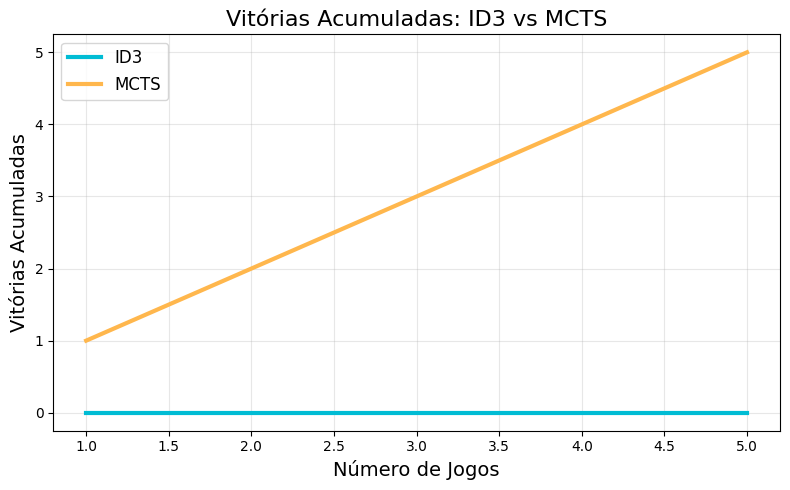

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

resultados = [1, 1, 1, 1, 1]  # 5 vitórias do MCTS

# Acumular vitórias
vitorias_id3 = np.cumsum([1 if r == 0 else 0 for r in resultados])
vitorias_mcts = np.cumsum([1 if r == 1 else 0 for r in resultados])

num_jogos = np.arange(1, len(resultados) + 1)  

plt.figure(figsize=(8, 5))
plt.plot(num_jogos, vitorias_id3, label='ID3', color='#00bcd4', linewidth=3)
plt.plot(num_jogos, vitorias_mcts, label="MCTS", color='#ffb74d', linewidth=3)
plt.xlabel('Número de Jogos', fontsize=14)
plt.ylabel('Vitórias Acumuladas', fontsize=14)
plt.title('Vitórias Acumuladas: ID3 vs MCTS', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Análise dos Resultados: Vitórias Acumuladas do MCTS vs ID3

No gráfico apresentado, comparamos as vitórias acumuladas entre o **MCTS (Monte Carlo Tree Search)** e **ID3 (Árvore de Decisão)**. O eixo horizontal representa o número de jogos disputados, enquanto o eixo vertical mostra o número acumulado de vitórias de cada um.

## Resultados Observados

Neste experimento, o MCTS venceu os 5 jogos disputados, enquanto a arvore de decisão com ID3 não obteve nenhuma vitória. Isto significa que o MCTS demonstrou um desempenho superior neste conjunto específico de partidas, como se pode observar na curva de vitórias acumuladas que sobe até 5 para o MCTS e mantém-se em 0 para o ID3.

## Por que razão o MCTS venceu todos os jogos?

O Monte Carlo Tree Search é um algoritmo de procura baseado em simulações estatísticas que explora possíveis jogadas futuras de forma muito eficaz, equilibrando exploração e aproveitamento (utilizando, por exemplo, a fórmula UCT, a qual foi utilizada neste trabalho). Isto permite ao MCTS tomar decisões estratégicas mais sólidas, especialmente em jogos com um espaço grande de possibilidades, como o Connect Four.

Por outro lado, o algoritmo ID3 baseia-se numa árvore de decisão construída a partir de um conjunto de dados de treino. A sua eficácia depende muito da qualidade e quantidade desses dados. Caso o conjunto de treino não cubra suficientemente as estratégias possíveis, ou o modelo não generalize bem, a sua performance pode ser inferior.


# **Média de Jogadas do MCTS por jogo**

### Código que gerou o dataset para as estatísticas

In [ ]:
'''from mcts import MCTS
from connect_four import ConnectFour
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

dataset = []
num_samples = 500  # número de exemplos
total_moves = 0      # soma total das jogadas
num_games = 0        # número de partidas simuladas
moves_per_game = []  # lista para guardar o número de jogadas por partida

for _ in tqdm(range(num_samples), desc="Gerando exemplos"):
    game = ConnectFour()
    num_moves = random.randint(0, 20)
    moves_this_game = 0  # contador de jogadas desta partida

    for _ in range(num_moves):
        valid_moves = game.get_valid_locations()
        if not valid_moves:
            break
        move = random.choice(valid_moves)
        game.drop_piece(move, game.get_current_player())
        game.switch_player()
        moves_this_game += 1

    # Ignora estados terminais
    if game.check_win(1) or game.check_win(2) or game.is_tie():
        continue

    # Executa o MCTS para estados não terminais
    mcts = MCTS(game, iterations=1000)
    mcts.run()
    best_move = mcts.get_best_move()

    if best_move is None:
        continue

    estado = []
    for row in game.board:
        estado.extend(row)
    exemplo = {f'cell_{i}': valor for i, valor in enumerate(estado)}
    exemplo['player'] = game.get_current_player()
    exemplo['move'] = best_move
    dataset.append(exemplo)

    # Inclui estados terminais no dataset
    if game.check_win(1) or game.check_win(2) or game.is_tie():
        estado = []
        for row in game.board:
            estado.extend(row)
        exemplo = {f'cell_{i}': valor for i, valor in enumerate(estado)}
        exemplo['player'] = game.get_current_player()
        exemplo['move'] = None
        dataset.append(exemplo)

    # Atualiza estatísticas
    total_moves += moves_this_game
    num_games += 1
    moves_per_game.append(moves_this_game)

if len(dataset) == 0:
    print("Erro: Nenhum exemplo foi gerado. O dataset está vazio.")
else:
    df = pd.DataFrame(dataset)
    df.to_csv('connect4_mcts_dataset.csv', index=False)
    print(f"Dataset gerado com sucesso! Total de exemplos: {len(dataset)}")
    if num_games > 0:
        media_jogadas = total_moves / num_games
        print(f"Número médio de jogadas por partida: {media_jogadas:.2f}")
    else:
        print("Nenhuma partida válida foi simulada.")

    # Gera o gráfico
    plt.figure(figsize=(8,5))
    plt.hist(moves_per_game, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribuição do Número de Jogadas por Partida')
    plt.xlabel('Número de Jogadas')
    plt.ylabel('Frequência')
    plt.grid(axis='y', alpha=0.75)
    plt.axvline(media_jogadas, color='red', linestyle='dashed', linewidth=2, label=f'Média = {media_jogadas:.2f}')
    plt.legend()
    plt.savefig('distribuicao_jogadas_por_partida.png')
    plt.show()'''


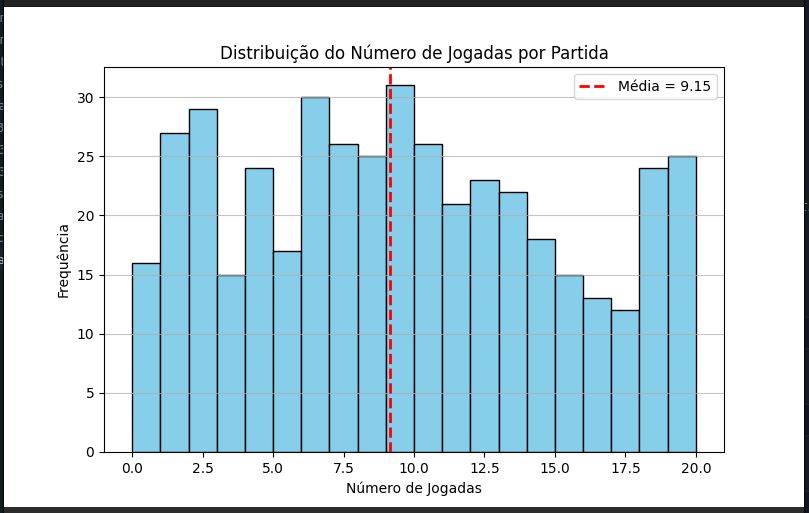

Durante as simulações realizadas com o algoritmo MCTS, registou-se uma média de 9,15 jogadas por jogo. Este valor indica que, em média, as partidas são resolvidas em poucas jogadas, o que demonstra a eficiência do MCTS na procura de soluções rápidas e na identificação de caminhos vencedores ou situações de empate no Connect Four. Esta média reflete a capacidade do algoritmo em explorar o espaço de decisões de forma estratégica, reduzindo o número de movimentos necessários para terminar cada partida.

# **Tempo médio de jogada**

### Código que gerou o dataset para as estatísticas

In [ ]:
"""import pandas as pd
import time
from tqdm import tqdm

from ID3_MCTS import predict_connect4_move
from connect_four import ConnectFour

from mcts import MCTS
import pickle
from ID3_MCTS import DecisionTree, train_tree, predict_connect4_move
import pickle

num_games = 50 # Número de partidas a simular
csv_filename = "tempos_mcts_vs_id3.csv"
resultados = []
import pickle
with open("connect4_tree.pkl", "rb") as f:
    tree = pickle.load(f)


for _ in tqdm(range(num_games), desc=" partidas"):
    game = ConnectFour()
    moves_this_game = 0
    tempos_mcts = []
    tempos_id3 = []
    vencedor = 0

    while not game.check_win(1) and not game.check_win(2) and not game.is_tie():
        if game.get_current_player() == 1:
            # MCTS joga
            start = time.time()
            mcts = MCTS(game, iterations=400)
            mcts.run()
            move = mcts.get_best_move()
            end = time.time()
            tempos_mcts.append(end - start)
        else:
            # ID3 joga
            start = time.time()
            valid_moves = game.get_valid_locations()
            move = predict_connect4_move(tree, game.get_board(), game.get_current_player(), valid_moves)
            end = time.time()
            tempos_id3.append(end - start)
        game.drop_piece(move, game.get_current_player())
        game.switch_player()
        moves_this_game += 1

    # Determina vencedor
    if game.check_win(1):
        vencedor = 1
    elif game.check_win(2):
        vencedor = 2
    else:
        vencedor = 0  # Empate

    tempo_medio_mcts = sum(tempos_mcts) / len(tempos_mcts) if tempos_mcts else 0
    tempo_medio_id3 = sum(tempos_id3) / len(tempos_id3) if tempos_id3 else 0

    resultados.append({
        "num_jogadas": moves_this_game,
        "vencedor": vencedor,
        "tempo_medio_mcts": tempo_medio_mcts,
        "tempo_medio_id3": tempo_medio_id3
    })

# Salva CSV
df = pd.DataFrame(resultados)
df.to_csv(csv_filename, index=False)
print(f"CSV '{csv_filename}' gerado com sucesso!")

# Estatísticas rápidas e gráfico dos tempos
media_mcts = df['tempo_medio_mcts'].mean()
media_id3 = df['tempo_medio_id3'].mean()
print(f"Tempo médio MCTS: {media_mcts:.4f} s")
print(f"Tempo médio ID3: {media_id3:.4f} s")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(['MCTS', 'ID3'], [media_mcts, media_id3 * 1000], color=['royalblue', 'orange'])
plt.ylabel('Tempo médio por jogada (ms)')
plt.title('Tempo Médio de Decisão por Jogada (MCTS vs ID3)')
plt.savefig('tempo_medio_mcts_vs_id3_ms.png')
plt.show()
"""

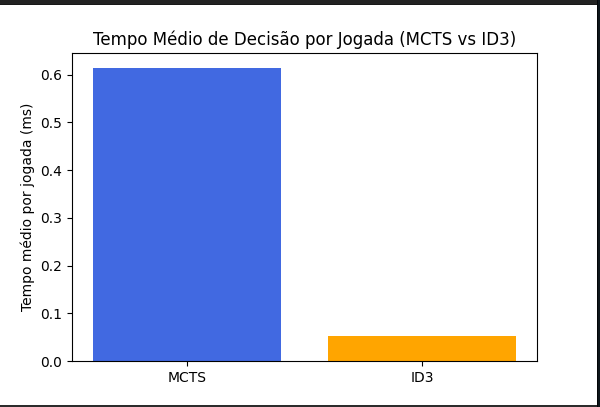

Durante as simulações, verificou-se uma diferença muito significativa entre o tempo médio de decisão por jogada do MCTS e do ID3. O algoritmo ID3 revelou-se extremamente rápido, com tempos de decisão da ordem dos microssegundos (por exemplo, cerca de 0,000045 segundos por jogada), enquanto o MCTS apresentou um tempo médio de decisão de aproximadamente 0,62 segundos por jogada. Esta diferença deve-se ao facto de o ID3 apenas percorrer uma árvore de decisão já construída, enquanto o MCTS realiza centenas de simulações para cada jogada. Assim, o ID3 destaca-se pela sua rapidez na tomada de decisão, tornando-o muito mais eficiente em termos de tempo quando comparado com o MCTS.

# **POSSÍVEIS MELHORIAS**

### Melhorias Possíveis no Algoritmo ID3 para o Connect Four

O algoritmo ID3, apesar de ser uma abordagem clássica e eficiente para construção de árvores de decisão, apresenta algumas limitações quando aplicado a jogos complexos como o Connect Four. Abaixo listam-se algumas estratégias e melhorias que podem ser implementadas para tornar o ID3 mais inteligente e competitivo neste contexto.

**1- Utilização de Algoritmos de Árvore de Decisão mais Avançados**

    - C4.5 ou CART: São evoluções do ID3 que conseguem lidar melhor com atributos contínuos, valores ausentes e implementam técnicas de poda para evitar o sobreajuste (overfitting).

    - Poda (Pruning): Implementar técnicas de poda (pré ou pós-poda) para evitar que a árvore cresça excessivamente, tornando-se demasiado específica para os dados de treino.

**2-Melhoria dos Atributos (Features) Utilizados**

    -Criação de Features Estratégicas: Em vez de apenas utilizar o estado bruto do tabuleiro, podem ser criadas features mais informativas.

    -Incorporação de Informação Temporal: Adicionar atributos que representem o turno atual ou o histórico recente de jogadas pode ajudar a capturar padrões dinâmicos do jogo.

**3-Balanceamento e Qualidade do Dataset**

    -Balanceamento: Garantir que o conjunto de treino é equilibrado, ou seja, contém exemplos variados de todas as possíveis jogadas e situações de jogo.

    -Aumento de Dados: Gerar mais exemplos através de simulações (por exemplo, usando MCTS) para enriquecer o dataset e cobrir mais cenários estratégicos.


**4-Integração com Outras Técnicas**

    -Ensemble Learning: Utilizar métodos como Random Forests ou Boosting para aumentar a robustez e precisão das decisões.
